## Build phosphoste network

This notebook provides the code to create a network based on kinase-substrate interactions and the annotated effect of phosphorylation (based on PhosphositePlus) on the activity of the substrate.

In [1]:
%%time
from omniflow_project.core.network import Network
from omniflow_project._visual.visualize_network import NetworkVisualizer
from omniflow_project._inputs.resources import Resources
from omniflow_project._annotations.gene_ontology import Ontology
import omnipath as op
import pandas as pd

/home/eirini/anaconda3/envs/omniflow_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1.71 s, sys: 389 ms, total: 2.09 s
Wall time: 2.1 s


## 1. Specify kinase-substrate interaction file and phosphosite effect annotation

In this example, both files we utilize are from PhosphositePlus.

In [2]:
kinase_int_file = ("/home/eirini/Documents/Git/omniflow_project/Kinase_Substrate_Dataset")
phospho_effect_file = ("/home/eirini/Documents/Git/omniflow_project/Regulatory_sites")

## 2. Add interactions as a resource database

The *_process_psp_interactions_* function parses the provided files to create an interaction database in the Omnipath format.

In [22]:
resources = Resources()
interactions = resources.process_psp_interactions(kinase_int_file, phospho_effect_file, "human", expand=False)
resources.add_database(interactions)

/home/eirini/anaconda3/envs/omniflow_env/lib/python3.10/site-packages/omniflow_project/_inputs/resources.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kinase_int_filtered['target'] = kinase_int_filtered['SUB_GENE'] + '_' + kinase_int_filtered['SUB_MOD_RSD']
/home/eirini/anaconda3/envs/omniflow_env/lib/python3.10/site-packages/omniflow_project/_inputs/resources.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phospho_effect_filtered['MOD_RSD'] = phospho_effect_filtered['MOD_RSD'].apply(lambda x:

In [24]:
#inspect database
interactions

,source,target,is_directed,consensus_direction,consensus_stimulation,consensus_inhibition,is_stimulation,is_inhibition
0,EIF2AK1,EIF2S1_S52,True,False,False,False,1,1
2,PRKCD,HDAC5_S259,True,False,False,False,1,1
3,PRKCD,PTPRA_S204,True,False,False,False,1,0
4,PRKCD,BCL2_S70,True,False,False,False,0,1
6,PRKCD,SLC9A1_S648,True,False,False,False,0,1
...,...,...,...,...,...,...,...,...
14483,NUAK1,CASP6_S257,True,False,False,False,0,1
14484,NUAK1,TP53_S392,True,False,False,False,1,0
14489,NUAK1,TP53_S15,True,False,False,False,1,1
14491,ULK2,STING1_S366,True,False,False,False,1,0


### 3. Define a set of phosphosites we are interested in

In [16]:
genes = ['SMAD3_S423', 'SMAD3_S425', 'TP53_S15', 'AKT1S1_T246', 'GSK3B_S9', 'GSK3B_S21', 'AKT1_S473', 'HSPB1_S78', 'HSPB1_S82', 'MAPK14_T180', 'MAPK14_Y182', 'MAP2K1_S218', 'MAP2K1_S222', 'RPS6KA1_S380', 'CREB1_S133', 'NFKBIA_S32', 'NFKBIA_S36', 'MTOR_S2448', 'JUN_S63', 'EGFR_Y1068', 'MAPK3_T202', 'MAPK3_Y204', 'PTPN11_Y542', 'STAT3_Y705', 'CHEK2_T68', 'RELA_S536', 'MARCKS_S170']
genes = ['SMAD3_S423', 'SMAD3_S425', 'TP53_S15', 'AKT1S1_T246', 'GSK3B_S9', 'GSK3B_S21', 'AKT1_S473', 'HSPB1_S78', 'HSPB1_S82', 'MAPK14_T180', 'MAPK14_Y182', 'MAP2K1_S218', 'MAP2K1_S222', 'RPS6KA1_S380', 'CREB1_S133', 'NFKBIA_S32', 'NFKBIA_S36', 'MTOR_S2448', 'JUN_S63', 'EGFR_Y1068', 'MAPK3_T202', 'MAPK3_Y204', 'PTPN11_Y542', 'STAT3_Y705', 'CHEK2_T68', 'RELA_S536', 'MARCKS_S170','SMAD3', 'TP53', 'AKT1S1', 'GSK3B', 'AKT1', 'HSPB1', 'MAPK14', 'MAP2K1', 'RPS6KA1', 'CREB1', 'NFKBIA', 'MTOR', 'JUN', 'EGFR', 'MAPK3', 'PTPN11', 'STAT3', 'CHEK2', 'RELA', 'MARCKS']

#genes = ['SMAD3_S423', 'SMAD3_S425', 'TP53_S15', 'AKT1S1_T246', 'GSK3B_S9', 'GSK3B_S21', 'AKT1_S473', 'HSPB1_S78']

### 4. Build network

In [17]:
%%time
new_net1 = Network(genes, resources=resources.interactions)

CPU times: user 113 ms, sys: 4.04 ms, total: 117 ms
Wall time: 113 ms


In [18]:
%%time
new_net1.connect_nodes(only_signed=True)

CPU times: user 5.14 s, sys: 4.22 ms, total: 5.14 s
Wall time: 5.14 s


In [19]:
%%time
new_net1.complete_connection(mode="ALL", maxlen=10, k_mean="extensive", only_signed=True, connect_node_when_first_introduced=True)

looking for paths in the network with length:  0  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  1  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  2  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  3  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  4  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  5  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  6  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  7  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  8  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  9  for node  SMAD3_S423  and  SMAD3_S425
looking for paths in the network with length:  10  for node  SMAD3_S423  and  SMAD3_S425
i_search =  4
Looking for paths

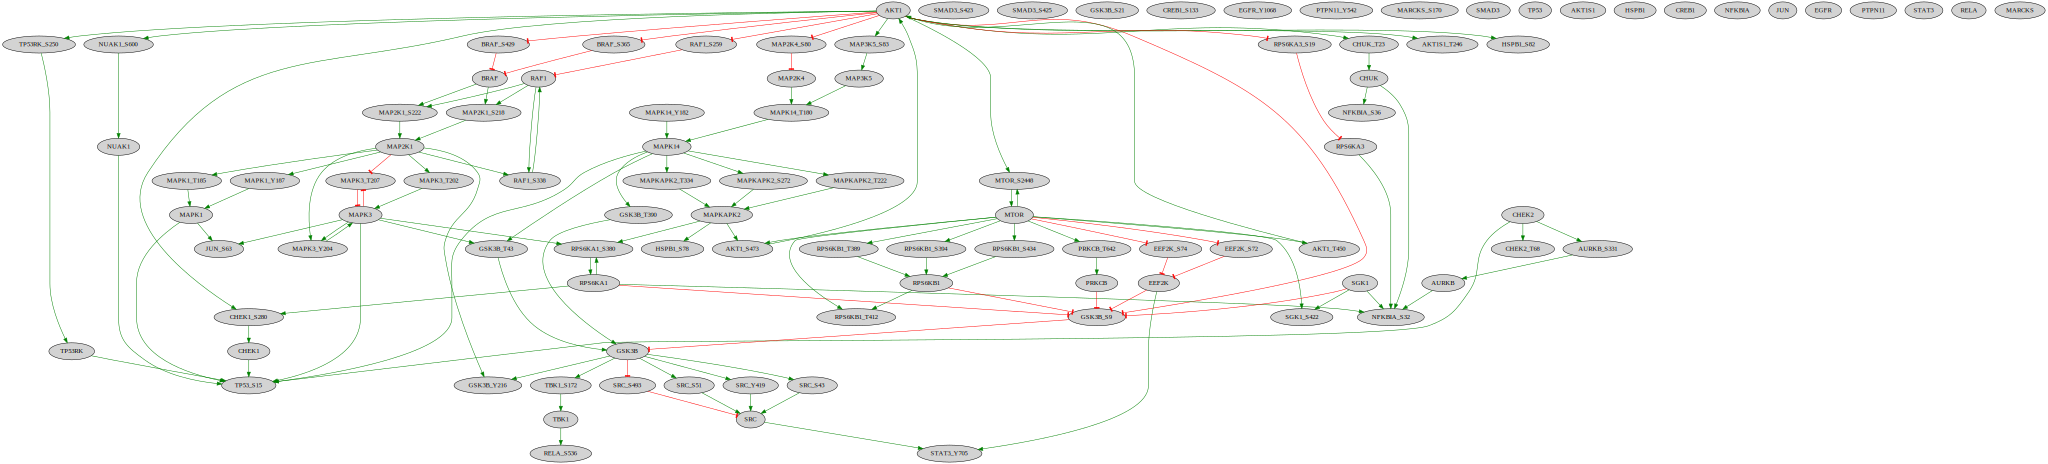

In [21]:
visualizer1 = NetworkVisualizer(new_net1, color_by='effect')
visualizer1.render()